**Construcción de una red de coexpresión genética: antecedentes y enfoque**

<p style="font-family:'Times New Roman'">
 En esta sección, les explicaré cómo crear una red de coexpresión génica. Antes de profundizar en los pasos prácticos, es importante comprender una característica clave de este tipo de análisis. A diferencia de una red de interacción proteína-proteína (PPI), que requiere una lista pregenerada de genes expresados ​​diferencialmente (GED) como entrada, el análisis de redes de coexpresión puede realizarse incluso con datos de muestra de una sola afección. Esto hace que el análisis de coexpresión sea particularmente versátil, ya que no depende de un análisis previo de expresión diferencial. En cambio, identifica patrones de expresión compartida entre genes en su conjunto de datos, revelando módulos de genes corregulados que pueden ofrecer información única sobre el marco regulatorio de la afección biológica en estudio.
 
 <p style="font-family:'Times New Roman'">
 Para este tutorial, usaremos un archivo llamado countlist_5xFAD. Este conjunto de datos incluye datos de expresión génica de 20 muestras: 10 de ratones mutantes 5xFAD y 10 de ratones control de tipo salvaje (WT). Este archivo es el resultado de un análisis previo que realicé , que explora las similitudes, diferencias y características superpuestas entre tres modelos de ratones mutantes de la enfermedad de Alzheimer. Mientras trabajamos con este conjunto de datos específico, los métodos que demostraré se pueden aplicar a cualquier conjunto de datos con formato CSV, donde las filas representan genes y las columnas muestras, con solo pequeños ajustes en el código.

<p style="font-family:'Times New Roman'">
Nota: Puede usar este código para recuperar los datos del mouse 5xFAD (+ sus datos de control WT correspondientes) de GEO, luego limpiarlos y reformatearlos, de modo que el archivo de salida resultante countlist_5xFADsea el mismo conjunto de datos con el que estoy trabajando en este tutorial.

<p style="font-family:'Times New Roman'">
Cabe destacar que, al tener un conjunto de datos con dos condiciones experimentales, como tratamiento y control, se puede elegir cómo abordar el análisis de coexpresión. Se puede (1) combinar todos los datos en un solo análisis o (2) dividir el conjunto de datos por condición. Cada enfoque tiene sus ventajas según la pregunta de investigación que se esté abordando. Un análisis de red de coexpresión combinado, que agrupa los datos de ambas condiciones, se utiliza generalmente cuando el objetivo es identificar módulos genéticos conservados en todas las condiciones. Estos módulos conservados suelen representar procesos o vías biológicas fundamentales que no se ven alterados significativamente por el tratamiento experimental (o, en este caso, la progresión de la enfermedad).

<p style="font-family:'Times New Roman'">
Por otro lado, los análisis de coexpresión por separado para los grupos de tratamiento y control son particularmente útiles si se desea comparar las estructuras de la red e identificar módulos específicos de la enfermedad o genes nodales. Al analizar cada grupo de forma independiente, se pueden descubrir módulos genéticos exclusivos de una enfermedad específica. Por ejemplo, los módulos presentes únicamente en el grupo 5xFAD podrían representar vías biológicas alteradas en la enfermedad de Alzheimer, mientras que los exclusivos del grupo WT podrían reflejar redes reguladoras normales. Este enfoque también permite comparar propiedades de la red, como la conectividad, la identificación de genes nodales y la composición de los módulos, entre ambos grupos, lo que puede revelar diferencias cruciales en la regulación génica en condiciones normales y en condiciones de enfermedad.

<p style="font-family:'Times New Roman'">
En la práctica, los investigadores suelen comenzar con un análisis combinado para identificar módulos compartidos y asociados al genotipo. Posteriormente, pueden refinar sus hallazgos realizando análisis específicos de cada grupo para explorar más a fondo las diferencias en la topología de la red o la composición de los módulos, que es el enfoque que adoptaré en este tutorial. Este enfoque gradual —que comienza con una red combinada y continúa con redes específicas de cada grupo— no solo proporciona una perspectiva más amplia del sistema biológico, sino que también garantiza que no se pasen por alto los efectos sutiles específicos de cada condición.

<p style="font-family:'Times New Roman'">
Ahora, en el bloque de código a continuación, comenzaremos cargando las bibliotecas utilizadas en este tutorial, importando nuestros datos y luego calculando correlaciones por pares entre la expresión genética:

<p style="font-family:'Times New Roman'">
Nota: Limitaré este análisis a los primeros 100 genes de mi archivo countlist_5xFAD. Esto es para reducir la carga computacional, ya que el análisis de coexpresión puede ser muy costoso computacionalmente al usar conjuntos de datos grandes (y estoy usando un ordenador personal para ejecutar el código en este tutorial).

In [44]:
# Import all libraries for this tutorial
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load the count list CSV
file_path = 'countlist_5xFAD.csv'  # Path to your CSV file
data = pd.read_csv(file_path, index_col=0)

# Subset the data to the first 100 rows (genes) for testing 
data = data.dropna(subset=["Gene_Name"]) # Drop Gene_Name column 
data_subset = data.iloc[:100, :]  # Select the first 100 rows (genes)
data_subset = data_subset.set_index("Gene_Name") # Set Gene_Name as index

# Ensure the expression data is numeric
expression_data_numeric = data_subset.apply(pd.to_numeric, errors='coerce')

# Transpose the expression data to focus on gene co-expression (genes as columns)
expression_data_transposed = expression_data_numeric.T  

# Function to calculate pairwise correlations 
def calculate_correlation_matrix(expression_data):
    correlation_matrix = expression_data.corr(method="spearman")  # Spearman correlation
    return correlation_matrix

# Perform combined co-expression analysis and then display first few rows of results data frame 
combined_corr_matrix = calculate_correlation_matrix(expression_data_transposed)
combined_corr_matrix.head()

Gene_Name,Gnai3,Pbsn,Cdc45,H19,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,...,Tom1l2,Gpa33,Zfp385a,Itga5,Gabra2,Wdr77,Adora3,Atp5pb,Sox9,Hnrnpd
Gene_Name,,,,,,,,,,,,,,,,,,,,,
Gnai3,1.000000,NaN,0.805579,0.025942,0.637682,0.416484,0.956391,0.917293,0.890226,0.976307,...,0.945468,0.279265,0.870677,0.689993,0.945865,0.971429,0.816404,0.960902,0.903759,0.963910
Pbsn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cdc45,0.805579,NaN,1.000000,0.157632,0.510997,0.628412,0.812361,0.688773,0.675209,0.781381,...,0.813043,0.060847,0.780710,0.526019,0.722685,0.807086,0.713802,0.737756,0.778450,0.759610
H19,0.025942,NaN,0.157632,1.000000,0.317685,0.246538,0.112688,0.142684,0.033239,0.167473,...,0.055959,-0.222562,0.140251,0.124131,0.121605,0.038914,0.049896,0.068910,0.026753,0.109445
Scml2,0.637682,NaN,0.510997,0.317685,1.000000,0.422814,0.644490,0.644490,0.636925,0.706784,...,0.585708,-0.195451,0.558255,0.435282,0.627092,0.655837,0.752849,0.631630,0.614989,0.688364


<p style="font-family:'Times New Roman'">
Como puede ver, el resultado anterior es una matriz de correlación generada a partir de nuestro conjunto de datos de expresión génica mediante la correlación de Spearman. Tenga en cuenta que la matriz tiene el mismo conjunto de genes tanto en las filas como en las columnas (es una matriz de 100x100). Cada celda de la matriz representa la correlación de Spearman por pares entre dos genes según sus perfiles de expresión en todas las muestras. Los valores diagonales son todos 1,0 porque cada gen está perfectamente correlacionado consigo mismo, y los valores fuera de la diagonal representan el coeficiente de correlación de Spearman entre pares de genes (el coeficiente varía de -1, que es una correlación negativa perfecta, a 1, que es una correlación positiva perfecta). Además, notará que algunas celdas de la matriz muestran un valor NaN. Esto ocurre cuando al menos uno de los genes de un par tiene una expresión constante en todas las muestras (es decir, sin variación) o cuando el gen tiene un nivel de expresión muy bajo (casi cero) en las muestras.
<p style="font-family:'Times New Roman'">
Ahora que hemos creado nuestra matriz de correlación, la usaremos como entrada para crear una red de coexpresión, como se muestra a continuación:

In [59]:
# Create a Network from the Correlation Matrix
def create_network(corr_matrix, threshold=0.75):
    """
    Creates a co-expression network from a correlation matrix.
    Only edges with correlation >= threshold are added.
    """
    G = nx.Graph()
    for i, gene1 in enumerate(corr_matrix.index):
        for j, gene2 in enumerate(corr_matrix.columns):
            if i < j:  # Avoid duplicate pairs
                correlation = corr_matrix.iloc[i, j]
                if abs(correlation) >= threshold:  # Apply threshold
                    G.add_edge(gene1, gene2, weight=correlation)
    return G

# Define threshold for correlation
threshold = 0.75  

# Create combined network for all samples and analyze the combined network 
combined_network = create_network(combined_corr_matrix, threshold)
print(f"Combined Network: {combined_network.number_of_nodes()} nodes and {combined_network.number_of_edges()} edges")

Combined Network: 73 nodes and 1711 edges


<p style="font-family:'Times New Roman'">
Lo que produce el siguiente resultado:
<p style="font-family:'Times New Roman'">
Combined Network: 73 nodes and 1711 edges
<p style="font-family:'Times New Roman'">
El resultado anterior indica que, de los 100 genes de nuestro conjunto de datos, 73 están incluidos en nuestra red de coexpresión y existen 1711 aristas (conexiones) entre estos genes. La razón por la que tenemos 73 nodos en la red, y no 100, es que algunos genes podrían no tener una correlación significativa (por encima de threshold = 0.75) con otros genes y, por lo tanto, se excluyen de la red. Las aristas de nuestra red representan relaciones por pares entre genes basadas en su correlación. En otras palabras, existe una arista entre dos genes si el valor absoluto de su correlación es mayor o igual al umbral de 0,75.
<p style="font-family:'Times New Roman'">
Ahora, visualicemos el gráfico de nuestra red junto con los 10 genes centrales principales según el grado:
<p style="font-family:'Times New Roman'">
Lo que produce el siguiente resultado:

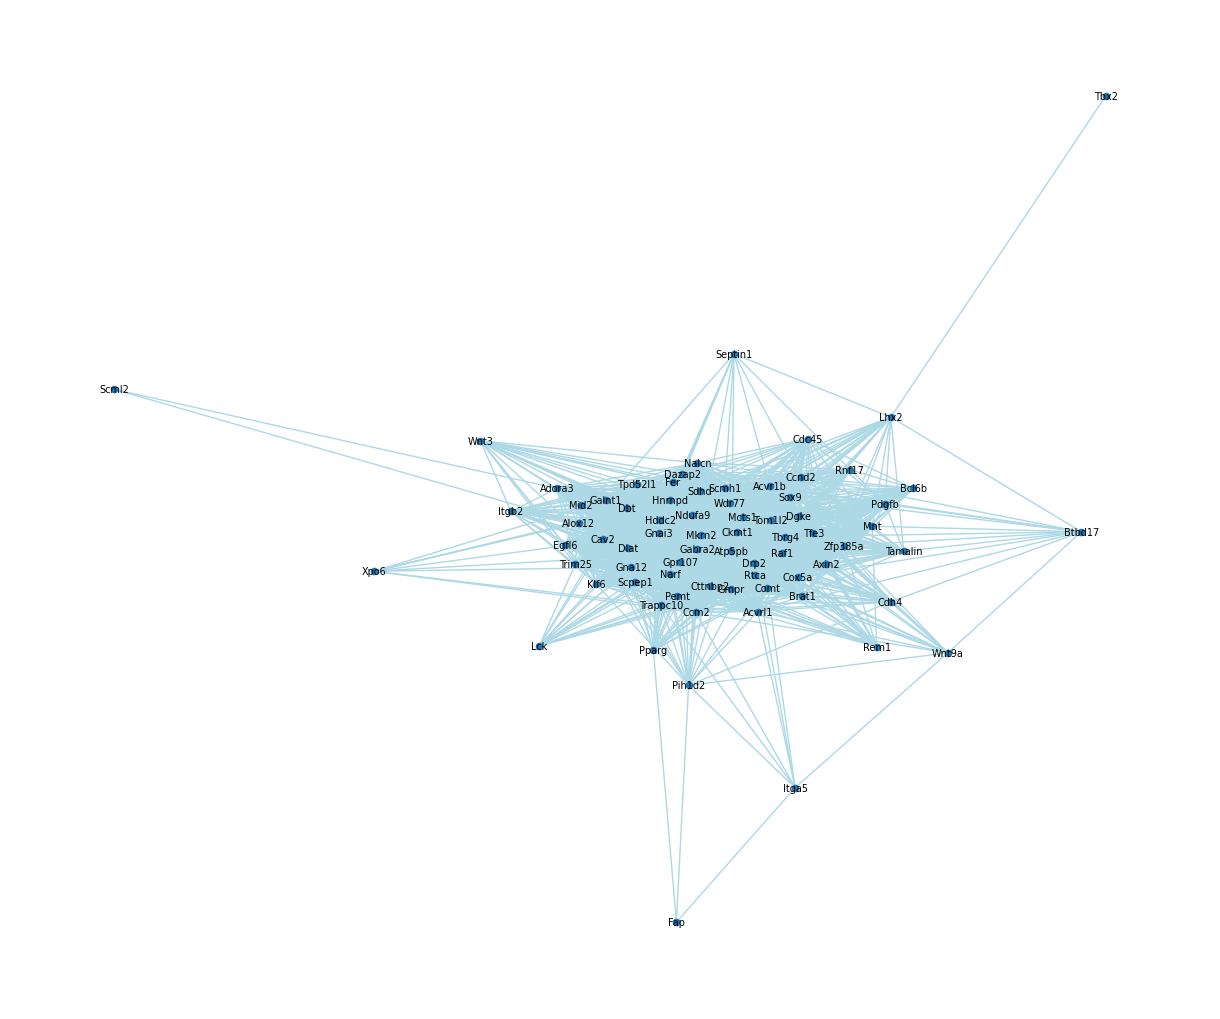

Top 10 hub genes:
[('Scmh1', 64), ('Atp5pb', 64), ('Gnai3', 63), ('Tbrg4', 63), ('Comt', 62), ('Dazap2', 62), ('Hnrnpd', 62), ('Drp2', 61), ('Dgke', 61), ('Hddc2', 61)]


In [61]:
# Visualize the network with all gene names as labels
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(combined_network, seed=42)
nx.draw(combined_network, pos, with_labels=False, node_size=20, edge_color="lightblue")
nx.draw_networkx_labels(combined_network, pos, labels={node: node for node in combined_network.nodes}, font_size=7)
plt.show()

# identify hub genes in network
degrees = dict(combined_network.degree())
sorted_genes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
print("Top 10 hub genes:")
print(sorted_genes[:10])

<p style="font-family:'Times New Roman'">
En la figura anterior se puede observar la red de coexpresión génica con nodos etiquetados por nombre de gen. Además, el código genera los 10 genes principales de la red de coexpresión, ordenados según el grado (es decir, el número de conexiones) de cada gen. Por ejemplo, Scmh1 tiene 64 conexiones (aristas) al igual que Atp5pb, lo que significa que estos genes se coexpresan con otros 65 genes con un umbral de correlación de 0,75 o superior.
<p style="font-family:'Times New Roman'">
Usar el grado para clasificar los nodos es una forma sencilla e intuitiva de identificar genes centrales, ya que refleja con cuántos otros genes se coexpresa un gen en particular por encima del umbral. Sin embargo, también podemos usar métricas más sofisticadas, como la centralidad de grado, el coeficiente de agrupamiento, la centralidad de intermediación y la centralidad del vector propio, que proporcionan información adicional sobre la estructura de la red y las relaciones entre los nodos, que exploraremos en la siguiente sección.

**Explorando la conectividad de la red de coexpresión genética**
<p style="font-family:'Times New Roman'">
En la última subsección, presenté las métricas de grado, centralidad de grado, coeficiente de agrupamiento, centralidad de intermediación y centralidad de vector propio. Cada una de estas métricas tiene sus propias fortalezas y ventajas, que describo brevemente a continuación:
<p style="font-family:'Times New Roman'">
Degree: El grado es el número de aristas (conexiones) que tiene un nodo determinado, lo que refleja con cuántos otros genes se coexpresa. Esta medida proporciona una medición sencilla y rápida de la conectividad de la red, a pesar de su simplicidad.
<p style="font-family:'Times New Roman'">
Degree Centrality: La centralidad de grado normaliza el grado de un nodo dividiéndolo entre el grado máximo posible en la red. Como resultado, proporciona una medida relativa del grado de conexión de un nodo con respecto a otros en la red, lo que la convierte en una métrica útil al comparar nodos en redes de diferentes tamaños.
<p style="font-family:'Times New Roman'">
Clustering Coefficient: El coeficiente de agrupamiento de un nodo mide la conectividad de sus vecinos, indicando su proximidad a la formación de un grafo completo (es decir, completamente conectado). Esta medida es útil para comprender la estructura de la red localizada y ayuda a identificar genes que forman parte de módulos estrechamente conectados.
<p style="font-family:'Times New Roman'">
Betweeness Centrality: La centralidad de intermediación mide la frecuencia con la que un nodo aparece en las rutas más cortas entre otros nodos de la red y, por lo tanto, identifica los nodos que actúan como puentes o cuellos de botella en la red. Los nodos con una alta centralidad de intermediación pueden actuar como reguladores o mediadores críticos en la red.
<p style="font-family:'Times New Roman'">
Eigenvector Centrality: Esta métrica mide la influencia de un nodo en la red en función de la influencia de sus vecinos. Una alta centralidad del vector propio indica que un gen está conectado a muchos nodos bien conectados y, por lo tanto, identifica nodos con influencia más allá de sus conexiones inmediatas (es decir, nodos con influencia global).
<p style="font-family:'Times New Roman'">
Para las redes de coexpresión, el grado, la centralidad de grado y el coeficiente de agrupamiento son los más utilizados. Sin embargo, si se analizan centros reguladores o genes involucrados en vías clave, la centralidad de vector propio o de intermediación podría proporcionar información más detallada. En el código a continuación, identificaremos los 10 genes principales en función de la centralidad de grado, el coeficiente de agrupamiento, la centralidad de intermediación y la centralidad de vector propio, y luego visualizaremos subparcelas para cada uno de estos conjuntos de genes:



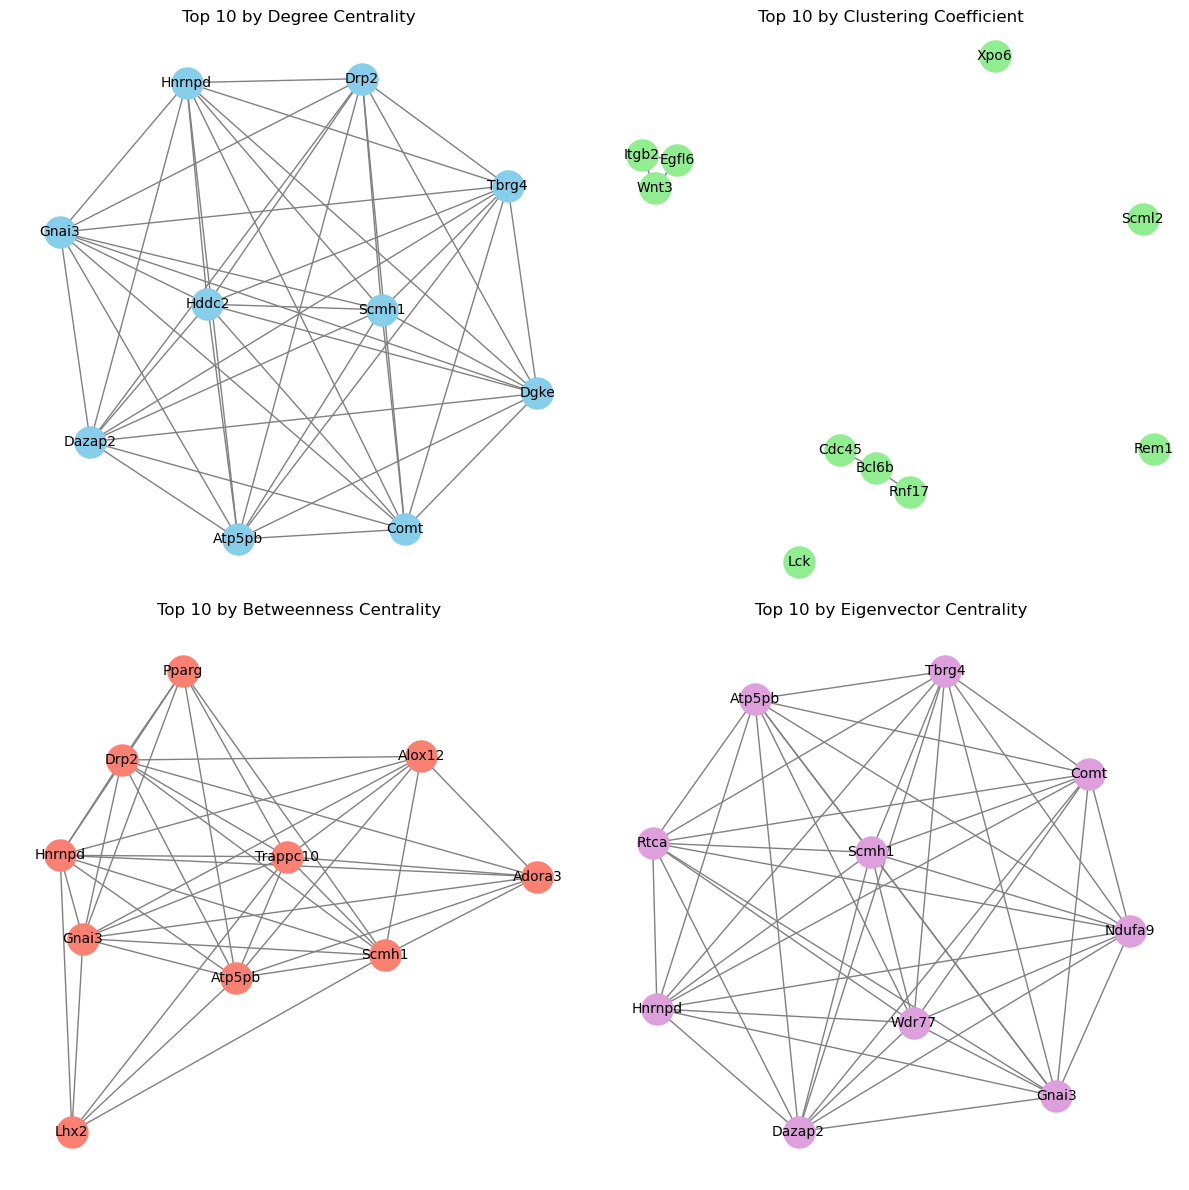

In [62]:
# Identify hub genes for each metric
degree_centrality = nx.degree_centrality(combined_network)
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
clustering = nx.clustering(combined_network)
sorted_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True)
betweenness = nx.betweenness_centrality(combined_network)
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
eigenvector = nx.eigenvector_centrality(combined_network)
sorted_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)

# Select top 10 genes for each metric
top_degree_centrality_genes = [gene for gene, _ in sorted_centrality[:10]]
top_clustering_genes = [gene for gene, _ in sorted_clustering[:10]]
top_betweenness_genes = [gene for gene, _ in sorted_betweenness[:10]]
top_eigenvector_genes = [gene for gene, _ in sorted_eigenvector[:10]]

# Create subgraphs
subgraph_degree_centrality = combined_network.subgraph(top_degree_centrality_genes)
subgraph_clustering = combined_network.subgraph(top_clustering_genes)
subgraph_betweenness = combined_network.subgraph(top_betweenness_genes)
subgraph_eigenvector = combined_network.subgraph(top_eigenvector_genes)

# Plot subgraphs
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Degree Centrality Subgraph
nx.draw(subgraph_degree_centrality,ax=axes[0, 0],with_labels=True,node_size=500,node_color="skyblue",font_size=10,edge_color="gray",)
axes[0, 0].set_title("Top 10 by Degree Centrality")

# Clustering Coefficient Subgraph
nx.draw(subgraph_clustering,ax=axes[0, 1],with_labels=True,node_size=500,node_color="lightgreen",font_size=10,edge_color="gray",)
axes[0, 1].set_title("Top 10 by Clustering Coefficient")

# Betweenness Centrality Subgraph
nx.draw(subgraph_betweenness,ax=axes[1, 0],with_labels=True,node_size=500,node_color="salmon",font_size=10,edge_color="gray",)
axes[1, 0].set_title("Top 10 by Betweenness Centrality")

# Eigenvector Centrality Subgraph
nx.draw(subgraph_eigenvector, ax=axes[1, 1],with_labels=True,node_size=500,node_color="plum",font_size=10,edge_color="gray",)
axes[1, 1].set_title("Top 10 by Eigenvector Centrality")

plt.tight_layout()
plt.show()

<p style="font-family:'Times New Roman'">
Como se puede ver en la figura anterior, el análisis identificó genes clave en la red de coexpresión basándose en cuatro medidas de centralidad, cada una de las cuales resalta diferentes aspectos de la topología de la red, revelando los roles de estos genes dentro de la estructura de red más amplia.
<p style="font-family:'Times New Roman'">
Genes principales por grado de centralidad: Los genes con mayor grado de centralidad, como Hddc2 y 5cmh1, están altamente conectados dentro de la red, lo que indica que podrían actuar como nodos que coordinan las interacciones entre otros genes. Estos nodos son cruciales para la cohesión y robustez general de la red.
<p style="font-family:'Times New Roman'">
Genes principales por coeficiente de agrupamiento: Varios genes, como Scml2, Rem1, Xpo6 y Lck, presentaron coeficientes de agrupamiento de 1,0, lo que sugiere que forman grupos estrechamente interconectados. Esto implica que estos genes podrían pertenecer a módulos altamente especializados o funcionalmente coherentes dentro de la red.
<p style="font-family:'Times New Roman'">
Genes principales por centralidad de intermediación: Genes como Alox12, Adora3, scmh1 y Trappc10 exhibieron una alta centralidad de intermediación, lo que indica su importancia como puentes o intermediarios que conectan diferentes partes de la red. Estos genes podrían desempeñar un papel fundamental en el flujo de información o la regulación entre módulos genéticos.
<p style="font-family:'Times New Roman'">
Genes principales por centralidad de vector propio: Genes como Dazap2, Hnrnpd, Gnai3 y Ndufa9 obtuvieron la clasificación más alta por centralidad de vector propio, lo que refleja su influencia en la red a través de sus conexiones con otros genes bien conectados. Estos genes pueden ser cruciales para mantener la estructura reguladora general de la red.
<p style="font-family:'Times New Roman'">
Ahora que hemos explorado la red combinada para nuestras muestras de tratamiento (ratones 5xFAD) y de control (ratones WT correspondientes), analizaremos las redes de coexpresión para cada uno de estos grupos por separado.

**Exploración de redes de coexpresión genética para muestras de tratamiento y control (por separado)**
<p style="font-family:'Times New Roman'">
Como se mencionó anteriormente, los análisis de coexpresión por separado para los grupos de tratamiento y control son particularmente útiles si se desea comparar las estructuras de la red e identificar módulos específicos de la enfermedad o genes nodales. Al analizar cada grupo de forma independiente, se pueden descubrir módulos genéticos exclusivos de una enfermedad específica. Por ejemplo, los módulos presentes únicamente en el grupo 5xFAD podrían representar vías biológicas alteradas en la enfermedad de Alzheimer, mientras que los exclusivos del grupo WT podrían reflejar redes reguladoras normales. Este enfoque también permite comparar propiedades de la red, como la conectividad, la identificación de genes nodales y la composición de los módulos, entre ambos grupos, lo que puede revelar diferencias cruciales en la regulación génica en condiciones normales y en condiciones de enfermedad.
<p style="font-family:'Times New Roman'">
En el bloque de código a continuación, crearemos redes de coexpresión genética para nuestras muestras de ratón 5xFAD y muestras de control WT, luego identificaremos los genes centrales en cada red:

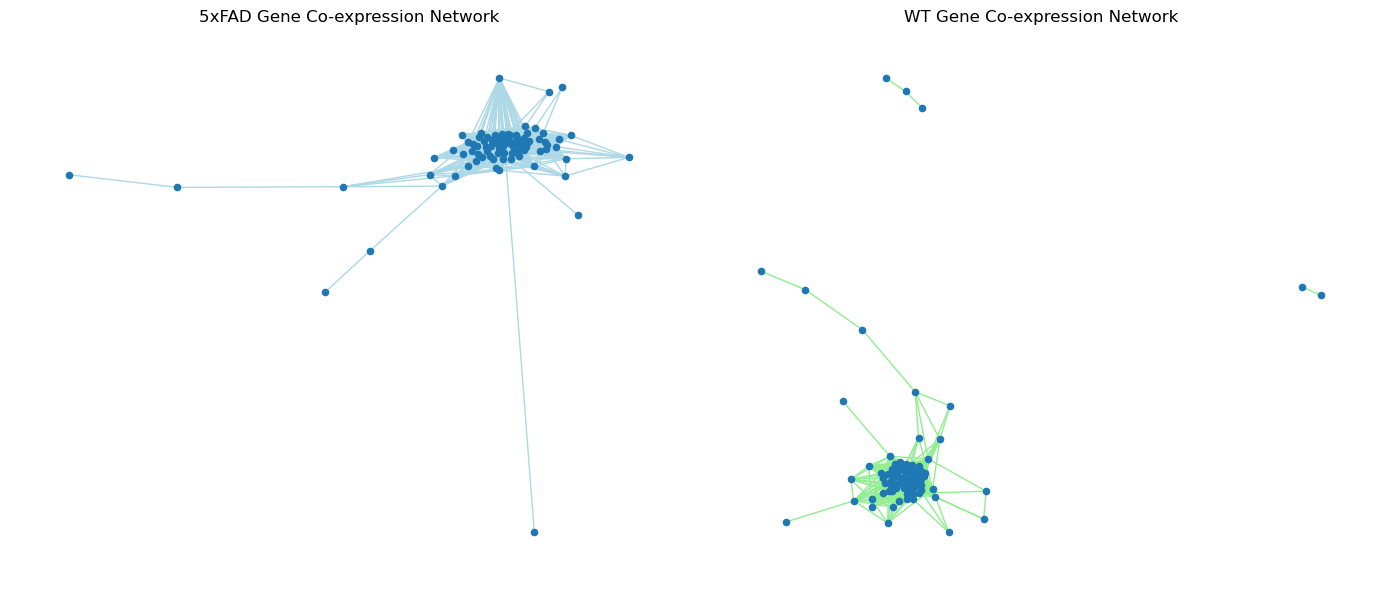

Top 10 hub genes in 5xFAD network:
[('Drp2', 70), ('Rtca', 69), ('Hnrnpd', 69), ('Dgke', 68), ('Alox12', 68), ('Comt', 68), ('Dazap2', 68), ('Mkrn2', 68), ('Cox5a', 67), ('Tfe3', 67)]

Top 10 hub genes in WT network:
[('Scmh1', 62), ('Gnai3', 61), ('Hddc2', 61), ('Dazap2', 61), ('Fer', 60), ('Btbd17', 60), ('Tpd52l1', 60), ('Comt', 60), ('Raf1', 60), ('Wdr77', 60)]


In [63]:
# Subset the data to exclude rows with NaN values in the "Gene_Name" column
data = data.dropna(subset=["Gene_Name"])

# Subset data for 5xFAD (mutant) and BL6 (WT) groups separately
five_x_fad_data = data.filter(regex="5xFAD")  # Select columns with "5xFAD" in their names
wt_data = data.filter(regex="BL6")  # Select columns with "BL6" in their names

# Ensure the expression data is numeric
five_x_fad_data_numeric = five_x_fad_data.apply(pd.to_numeric, errors='coerce')
wt_data_numeric = wt_data.apply(pd.to_numeric, errors='coerce')

# Set Gene_Name as the index for easier gene identification
five_x_fad_data_numeric = five_x_fad_data_numeric.set_index(data["Gene_Name"])
wt_data_numeric = wt_data_numeric.set_index(data["Gene_Name"])

# Select the first 100 rows (genes) for each group
five_x_fad_data_numeric = five_x_fad_data_numeric.iloc[:100, :]
wt_data_numeric = wt_data_numeric.iloc[:100, :]

# Transpose the expression data to focus on gene co-expression (genes as rows)
five_x_fad_transposed = five_x_fad_data_numeric.T  # Transpose for co-expression (samples as rows)
wt_transposed = wt_data_numeric.T  # Transpose for WT group

# Function to calculate pairwise correlations
def calculate_correlation_matrix(expression_data):

    correlation_matrix = expression_data.corr(method="spearman")  # Spearman correlation
    return correlation_matrix

# Calculate the correlation matrices separately for 5xFAD and WT groups
five_x_fad_corr_matrix = calculate_correlation_matrix(five_x_fad_transposed)
wt_corr_matrix = calculate_correlation_matrix(wt_transposed)

# Create networks for both treatment and control groups
def create_network(corr_matrix, threshold=0.7):
    G = nx.Graph()
    for i, gene1 in enumerate(corr_matrix.index):
        for j, gene2 in enumerate(corr_matrix.columns):
            if i < j:  # Avoid duplicate pairs
                correlation = corr_matrix.iloc[i, j]
                if abs(correlation) >= threshold:  # Apply threshold
                    G.add_edge(gene1, gene2, weight=correlation)
    return G

# Create networks for 5xFAD and WT
five_x_fad_network = create_network(five_x_fad_corr_matrix)
wt_network = create_network(wt_corr_matrix)

# Plot side-by-side subgraphs
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
pos_five_x_fad = nx.spring_layout(five_x_fad_network, seed=42)
nx.draw(five_x_fad_network, pos_five_x_fad, with_labels=False, node_size=20, edge_color="lightblue")
plt.title("5xFAD Gene Co-expression Network")
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
pos_wt = nx.spring_layout(wt_network, seed=42)
nx.draw(wt_network, pos_wt, with_labels=False, node_size=20, edge_color="lightgreen")
plt.title("WT Gene Co-expression Network")
plt.tight_layout()
plt.show()

# Identify and print top 10 hub genes for both networks
five_x_fad_degrees = dict(five_x_fad_network.degree())
sorted_five_x_fad_genes = sorted(five_x_fad_degrees.items(), key=lambda x: x[1], reverse=True)
print("Top 10 hub genes in 5xFAD network:")
print(sorted_five_x_fad_genes[:10])
wt_degrees = dict(wt_network.degree())
sorted_wt_genes = sorted(wt_degrees.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 hub genes in WT network:")
print(sorted_wt_genes[:10])

<p style="font-family:'Times New Roman'">
Ahora que hemos creado dos redes de coexpresión génica independientes, existen varios análisis interesantes que se pueden realizar. Para empezar, comparemos la densidad de ambas redes, lo que nos indicará el grado de conexión entre los genes de cada grupo:

In [66]:
density_five_x_fad = nx.density(five_x_fad_network)
density_wt = nx.density(wt_network)
print(f"Density of 5xFAD network: {density_five_x_fad}")
print(f"Density of WT network: {density_wt}")

Density of 5xFAD network: 0.5466452820101577
Density of WT network: 0.45499316005471957


<p style="font-family:'Times New Roman'">
Lo que produce el siguiente resultado:
<p style="font-family:'Times New Roman'">
Density of 5xFAD network: 0.5466452820101577
<p style="font-family:'Times New Roman'">
Density of WT network: 0.45499316005471957
<p style="font-family:'Times New Roman'">
la red de co-expresión del grupo 5xFAD tiene aproximadamente un 20% más de conexiones (en términos relativos) que la red del grupo WT. Los resultados sugieren que, en el modelo 5xFAD de Alzheimer, la red de co-expresión génica está más interconectada, lo que probablemente refleja una respuesta transcripcional global coordinada (posiblemente como consecuencia del estrés celular y la neuroinflamación), en contraste con la regulación más fina y específica observada en el control WT.
<p style="font-family:'Times New Roman'">
En redes biológicas reales (no aleatorias), la densidad nunca es cercana a 1 (100% de conexiones posibles). Una red con densidad ~0.45 indica un sistema complejo pero no caótico, con una organización estructurada. Este nivel sugiere que no todos los genes se co-expresan con todos, sino que existe una regulación selectiva y específica.
<p style="font-family:'Times New Roman'">
Refleja una organización modular eficiente:
Una densidad moderada (~45%) es típica de redes que tienen módulos o comunidades funcionales bien definidos. Los genes dentro de una misma vía metabólica o proceso celular probablemente estén fuertemente conectados entre sí, pero tienen menos conexiones con genes de otras vías. Esto permite especialización funcional sin interferencia excesiva. ~45% de conexiones significa que hay una integración suficiente para coordinar funciones celulares globales, pero también suficiente segregación para mantener procesos independientes.


<p style="font-family:'Times New Roman'">
A continuación, veremos el grado promedio de nodos en cada red, lo que puede indicar la conectividad general en cada condición:

In [67]:
avg_degree_five_x_fad = sum(dict(five_x_fad_network.degree()).values()) / len(five_x_fad_network.nodes)
avg_degree_wt = sum(dict(wt_network.degree()).values()) / len(wt_network.nodes)
print(f"Average degree in 5xFAD network: {avg_degree_five_x_fad}")
print(f"Average degree in WT network: {avg_degree_wt}")

Average degree in 5xFAD network: 47.01149425287356
Average degree in WT network: 38.674418604651166


<p style="font-family:'Times New Roman'">
Average degree in 5xFAD network: 47.01149425287356
<p style="font-family:'Times New Roman'">
Average degree in WT network: 38.674418604651166
<p style="font-family:'Times New Roman'">
5xFAD: 47.01 conexiones promedio por gen
WT: 38.67 conexiones promedio por gen
<p style="font-family:'Times New Roman'">
Esto significa que en promedio, cada gen en la red 5xFAD tiene aproximadamente 8.34 conexiones más (21.6% más) que en la red WT.
<p style="font-family:'Times New Roman'">
¿Qué nos indica esto biológicamente?
<p style="font-family:'Times New Roman'">
1. Confirmación de la mayor conectividad global:
<p style="font-family:'Times New Roman'">
La mayor densidad (0.5466 vs 0.4549) ya sugería más conexiones totales.
<p style="font-family:'Times New Roman'">
El mayor grado promedio confirma que esta mayor conectividad se distribuye entre los genes: cada gen individual tiene más conexiones en promedio.
<p style="font-family:'Times New Roman'">
2. Pérdida de especificidad regulatoria:
<p style="font-family:'Times New Roman'">
En condiciones normales (WT), cada gen se co-expresa con ~39 otros genes.
<p style="font-family:'Times New Roman'">
En el Alzheimer (5xFAD), esta cifra aumenta a ~47 genes.
<p style="font-family:'Times New Roman'">
Esto sugiere que los patrones de co-expresión se vuelven menos específicos: genes que normalmente se expresarían de manera independiente o en contextos específicos ahora muestran correlaciones de expresión.
<p style="font-family:'Times New Roman'">
3. Implicaciones para la regulación génica:
<p style="font-family:'Times New Roman'">
En WT (grado promedio = 38.67):
<p style="font-family:'Times New Roman'">
Especificidad funcional: Cada gen interactúa principalmente con genes de su misma vía o proceso.
<p style="font-family:'Times New Roman'">
Regulación precisa: Las relaciones de co-expresión están finamente ajustadas.
<p style="font-family:'Times New Roman'">
Modularidad preservada: Los genes dentro de módulos funcionales están fuertemente conectados entre sí, pero menos con genes de otros módulos.
<p style="font-family:'Times New Roman'">
En 5xFAD (grado promedio = 47.01):
<p style="font-family:'Times New Roman'">
"Mezcla" transcripcional: Los genes desarrollan conexiones con grupos más diversos.
<p style="font-family:'Times New Roman'">
Posible ruido regulatorio: Algunas conexiones pueden no ser funcionalmente relevantes.
<p style="font-family:'Times New Roman'">
Redes menos diferenciadas: Los límites entre módulos funcionales se difuminan.
<p style="font-family:'Times New Roman'">
4. Analogía útil:
<p style="font-family:'Times New Roman'">
WT: Como una empresa con departamentos bien definidos donde cada empleado (gen) interactúa principalmente con su equipo inmediato.
<p style="font-family:'Times New Roman'">
5xFAD: Como una empresa en crisis donde todos hablan con todos, creando más comunicación pero posiblemente menos productividad organizada.
<p style="font-family:'Times New Roman'">
5. Relación con fenómenos biológicos específicos del Alzheimer:
<p style="font-family:'Times New Roman'">
Posibles causas del aumento:
<p style="font-family:'Times New Roman'">
Respuesta inflamatoria global: La neuroinflamación activa factores de transcripción (como NF-κB) que regulan amplios programas génicos.
<p style="font-family:'Times New Roman'">
Estrés celular generalizado: El estrés del retículo endoplásmico, estrés oxidativo, etc., activan respuestas transcripcionales amplias.
<p style="font-family:'Times New Roman'">
Desregulación de "hubs" maestros: Genes reguladores clave podrían estar sobreexpresados o desregulados, coordinando más genes de lo normal.
<p style="font-family:'Times New Roman'">
Pérdida de inhibición/supresión: Mecanismos que normalmente suprimen conexiones inapropiadas podrían estar fallando.
<p style="font-family:'Times New Roman'">
6. Implicaciones para la resiliencia de la red:
<p style="font-family:'Times New Roman'">
WT: La conectividad moderada (~39 conexiones) balancea robustez y especialización.
<p style="font-family:'Times New Roman'">
5xFAD: La mayor conectividad puede hacer la red más frágil:
<p style="font-family:'Times New Roman'">
Más susceptibilidad a propagar perturbaciones.
<p style="font-family:'Times New Roman'">
Menos capacidad de aislar daños a módulos específicos.
<p style="font-family:'Times New Roman'">
Podría representar un estado de sobrecompensación celular que consume recursos.
<p style="font-family:'Times New Roman'">
Contexto con la densidad:
<p style="font-family:'Times New Roman'">
Ambas métricas cuentan la misma historia desde perspectivas complementarias:
<p style="font-family:'Times New Roman'">
Densidad: Perspectiva global de toda la red.
<p style="font-family:'Times New Roman'">
Grado promedio: Perspectiva del "ciudadano promedio" (gen promedio) en la red.
<p style="font-family:'Times New Roman'">
Ahora que hemos resaltado algunas diferencias entre ambas redes, realizaremos un análisis de genes centrales entre redes para determinar si existen genes centrales superpuestos entre ambas redes:

In [69]:
# Set of hub genes for 5xFAD and WT networks
hub_genes_five_x_fad = set([gene for gene, degree in sorted_five_x_fad_genes[:10]])
hub_genes_wt = set([gene for gene, degree in sorted_wt_genes[:10]])

# Find common and unique hub genes
common_hub_genes = hub_genes_five_x_fad.intersection(hub_genes_wt)
unique_five_x_fad_hub_genes = hub_genes_five_x_fad - hub_genes_wt
unique_wt_hub_genes = hub_genes_wt - hub_genes_five_x_fad
print(f"Common hub genes: {common_hub_genes}")
print(f"Unique 5xFAD hub genes: {unique_five_x_fad_hub_genes}")
print(f"Unique WT hub genes: {unique_wt_hub_genes}")

Common hub genes: {'Dazap2', 'Comt'}
Unique 5xFAD hub genes: {'Drp2', 'Dgke', 'Rtca', 'Cox5a', 'Hnrnpd', 'Mkrn2', 'Alox12', 'Tfe3'}
Unique WT hub genes: {'Wdr77', 'Btbd17', 'Tpd52l1', 'Raf1', 'Gnai3', 'Scmh1', 'Fer', 'Hddc2'}


<p style="font-family:'Times New Roman'">
El análisis anterior revela dos genes centrales comunes entre las redes 5xFAD y WT: Dazap2 y Comt. Esto sugiere que estos genes podrían desempeñar un papel fundamental en el mantenimiento de las relaciones de coexpresión centrales en ambas afecciones. Sin embargo, las redes también presentan genes centrales únicos y distintivos: ocho genes exclusivos de la red 5xFAD y ocho genes exclusivos de la red WT. Estos genes centrales únicos probablemente reflejan funciones reguladoras específicas de cada afección: los genes centrales específicos de 5xFAD podrían impulsar procesos relacionados con la patología del Alzheimer, mientras que los genes centrales específicos de WT mantienen funciones reguladoras normales.
<p style="font-family:'Times New Roman'">
Por último, analizaremos las distribuciones de peso de los bordes, lo que nos permite comparar la distribución de las fortalezas de correlación entre las redes 5xFAD y WT, indicándonos si ciertos pares de genes tienen una coexpresión más fuerte o más débil en un grupo en comparación con otro:

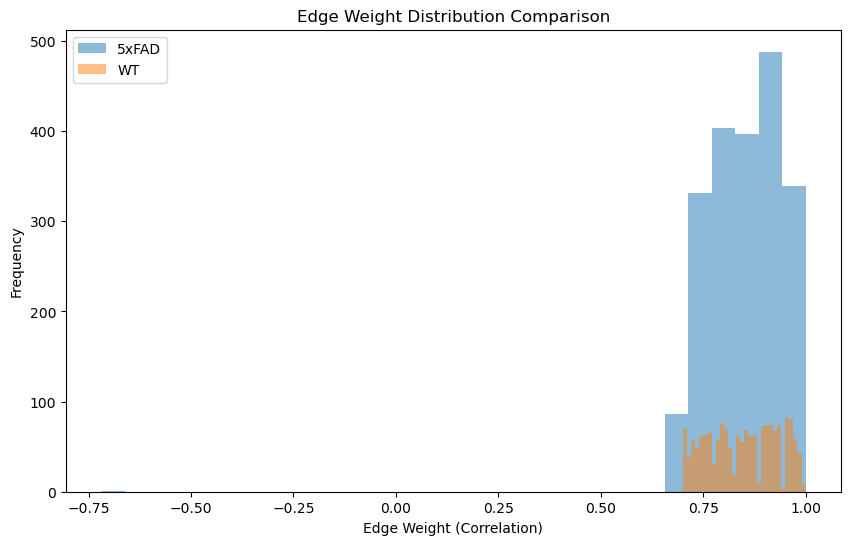

In [70]:
# Extract edge weights from 5xFAD and WT networks
edge_weights_five_x_fad = [data['weight'] for _, _, data in five_x_fad_network.edges(data=True)]
edge_weights_wt = [data['weight'] for _, _, data in wt_network.edges(data=True)]
plt.figure(figsize=(10, 6))
plt.hist(edge_weights_five_x_fad, bins=30, alpha=0.5, label='5xFAD')
plt.hist(edge_weights_wt, bins=30, alpha=0.5, label='WT')
plt.legend()
plt.title('Edge Weight Distribution Comparison')
plt.xlabel('Edge Weight (Correlation)')
plt.ylabel('Frequency')
plt.show()

<p style="font-family:'Times New Roman'">
Las distribuciones de pesos de borde revelan diferencias notables en los patrones de coexpresión entre las redes 5xFAD y WT. La red WT presenta una mayor frecuencia de correlaciones positivas fuertes (pesos de borde en el rango de 0,75 a 1,0), lo que sugiere relaciones de expresión génica más robustas y coordinadas en condiciones normales. Por el contrario, la red 5xFAD muestra una mayor presencia de correlaciones negativas (pesos de borde en torno a -0,75). Estos hallazgos sugieren que la patología de Alzheimer en el modelo 5xFAD puede alterar la arquitectura reguladora normal, reduciendo la coexpresión positiva e introduciendo interacciones desreguladas y oposicionales entre genes, lo que podría contribuir a procesos específicos de la enfermedad.

<p style="font-family:'Times New Roman'">
Escenario más probable basado en tus datos anteriores:
<p style="font-family:'Times New Roman'">
Dado que las redes 5xFAD tienen mayor densidad y grado promedio, es probable que:
<p style="font-family:'Times New Roman'">
Mayor frecuencia de correlaciones positivas fuertes en 5xFAD (azul):
<p style="font-family:'Times New Roman'">
Pico más alto en el rango de 0.5 a 1.0
<p style="font-family:'Times New Roman'">
Esto indicaría que en el Alzheimer, muchos pares de genes muestran una co-expresión altamente sincronizada
<p style="font-family:'Times New Roman'">
Reflejaría la activación coordinada de programas transcripcionales en respuesta al estrés patológico
<p style="font-family:'Times New Roman'">
Distribución más equilibrada en WT (naranja):
<p style="font-family:'Times New Roman'">
Posiblemente una curva más aplanada o bimodal
<p style="font-family:'Times New Roman'">
Correlaciones moderadas más frecuentes que extremas
<p style="font-family:'Times New Roman'">
Indicaría una regulación más matizada y específica
<p style="font-family:'Times New Roman'">
Interpretación por rangos de correlación:
<p style="font-family:'Times New Roman'">
Correlaciones Negativas (-0.75 a -0.25):
<p style="font-family:'Times New Roman'">
Si hay más correlaciones negativas en WT, sugeriría que en condiciones normales existen mecanismos de regulación compensatoria o de retroalimentación negativa que se pierden en la enfermedad.
<p style="font-family:'Times New Roman'">
Si hay más correlaciones negativas en 5xFAD, podría indicar desregulación disruptiva donde algunos genes se activan mientras otros se reprimen de manera coordinada.
<p style="font-family:'Times New Roman'">
Correlaciones Débiles (-0.25 a 0.25):
<p style="font-family:'Times New Roman'">
Si WT tiene más conexiones débiles, reflejaría una red con especificidad contextual: muchos genes solo se co-expresan bajo condiciones muy específicas.
<p style="font-family:'Times New Roman'">
Si 5xFAD tiene menos conexiones débiles, indicaría que la enfermedad reduce las relaciones sutiles en favor de conexiones más fuertes y generalizadas.
<p style="font-family:'Times New Roman'">
Correlaciones Positivas Fuertes (0.5 a 1.0):
<p style="font-family:'Times New Roman'">
El rango más informativo. Si 5xFAD domina aquí, confirmaría la hiper-sincronización transcripcional en la enfermedad.
<p style="font-family:'Times New Roman'">
Podría representar:
<p style="font-family:'Times New Roman'">
Activación masiva de vías inflamatorias
<p style="font-family:'Times New Roman'">
Respuesta coordinada al estrés celular
<p style="font-family:'Times New Roman'">
Pérdida de regulación independiente de genes
<p style="font-family:'Times New Roman'">
Relación con Hallazgos Previos:
<p style="font-family:'Times New Roman'">
Los resultados anteriores (mayor densidad y grado en 5xFAD) combinados con la distribución de pesos sugieren:
<p style="font-family:'Times New Roman'">
5xFAD probablemente muestra:
<p style="font-family:'Times New Roman'">
Una distribución sesgada hacia la derecha (más correlaciones positivas fuertes)
<p style="font-family:'Times New Roman'">
Posiblemente menos correlaciones negativas (pérdida de regulación antagonista)
<p style="font-family:'Times New Roman'">
Menos correlaciones cercanas a cero (reducción de relaciones específicas/contextuales)
<p style="font-family:'Times New Roman'">
WT probablemente muestra:
<p style="font-family:'Times New Roman'">
Una distribución más simétrica o uniforme
<p style="font-family:'Times New Roman'">
Mezcla equilibrada de correlaciones positivas, negativas y débiles
<p style="font-family:'Times New Roman'">
Reflejo de un sistema regulatorio complejo y multifacético
<p style="font-family:'Times New Roman'">
Implicaciones Biológicas:
<p style="font-family:'Times New Roman'">
Si 5xFAD tiene más correlaciones positivas fuertes:
<p style="font-family:'Times New Roman'">
Pérdida de independencia génica: Los genes pierden su capacidad de regularse independientemente
<p style="font-family:'Times New Roman'">
Respuesta en "bloque": Múltiples vías se activan simultáneamente como paquete
<p style="font-family:'Times New Roman'">
Posible falta de fine-tuning: La célula responde de manera menos específica a señales individuales
<p style="font-family:'Times New Roman'">
Si WT tiene correlaciones más diversas:
<p style="font-family:'Times New Roman'">
Especificidad regulatoria: Diferentes estímulos activan diferentes conjuntos de genes
<p style="font-family:'Times New Roman'">
Mecanismos de balance: Correlaciones negativas permiten respuestas compensatorias
<p style="font-family:'Times New Roman'">
Modularidad preservada: Los genes funcionan en módulos semi-independientes
<p style="font-family:'Times New Roman'">
Conclusión Probable:
<p style="font-family:'Times New Roman'">
Basándo en el patrón típico en estudios de neurodegeneración y los datos anteriores, es muy probable que la red 5xFAD muestre una distribución con mayor frecuencia de correlaciones positivas fuertes, mientras que la red WT muestre una distribución más equilibrada con mezcla de correlaciones positivas, negativas y débiles.
<p style="font-family:'Times New Roman'">
Esto reforzaría la hipótesis de que la patología del Alzheimer induce un estado transcripcional más homogéneo y menos diferenciado, donde los genes tienden a "moverse en manada" en lugar de regularse de manera independiente y específica.